In [1]:
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
import re
sns.set(font_scale=1.8, style="whitegrid")

In [2]:
dfHW_e = pd.DataFrame()
dfSW_e = pd.DataFrame()
dfHW_e = pd.read_table("logs/seed10/010/estatica/010estatica-10-switch-stats-hw.log", sep="\s+")
dfSW_e = pd.read_csv("logs/seed10/010/estatica/010estatica-10-switch-stats-sw.log", sep="\s+")
remover = ['MetDrps','MetMods','GroMods','PktsIn','PktsOut','MetEntr','MetUsag','GroEntr','GroUsag','BufPkts','BufUsag']
for item in remover:
    del dfHW_e[item]
    del dfSW_e[item]
dfHW_e['Switch'] = 'HW'
dfSW_e['Switch'] = 'SW'
dfSwitch_e = pd.concat([dfHW_e, dfSW_e], ignore_index=True)

Text(0.5, 1.0, 'Estatica')

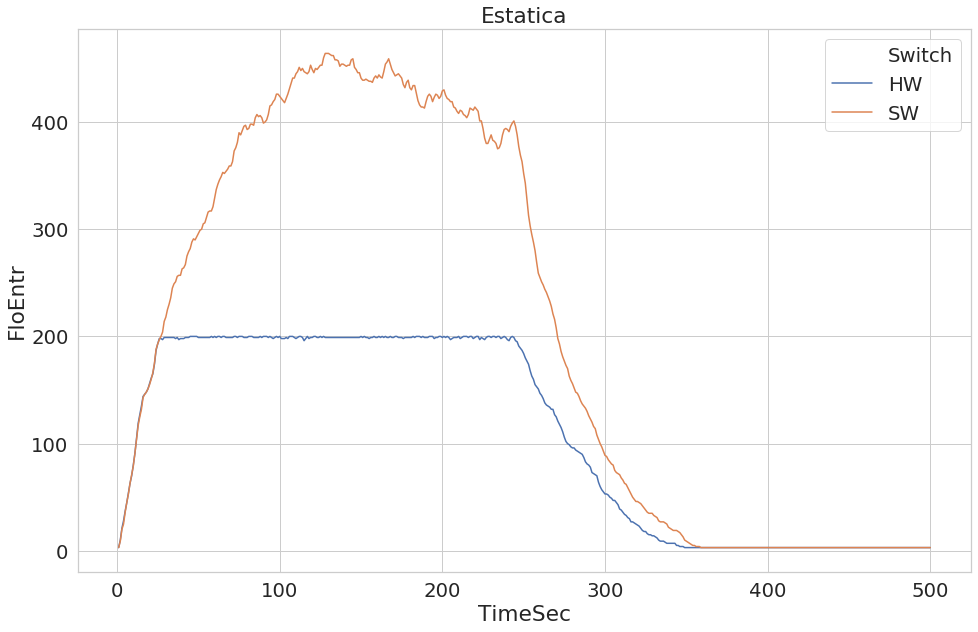

In [3]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_e)
plt.title('Estatica')

In [4]:
dfHW_d = pd.DataFrame()
dfSW_d = pd.DataFrame()
dfHW_d = pd.read_table("logs/seed10/010/dinamica/010dinamica-10-switch-stats-hw.log", sep="\s+")
dfSW_d = pd.read_csv("logs/seed10/010/dinamica/010dinamica-10-switch-stats-sw.log", sep="\s+")
for item in remover:
    del dfHW_d[item]
    del dfSW_d[item]
dfHW_d['Switch'] = 'HW'
dfSW_d['Switch'] = 'SW'
dfSwitch_d = pd.concat([dfHW_d, dfSW_d], ignore_index=True)

Text(0.5, 1.0, 'Dinamica')

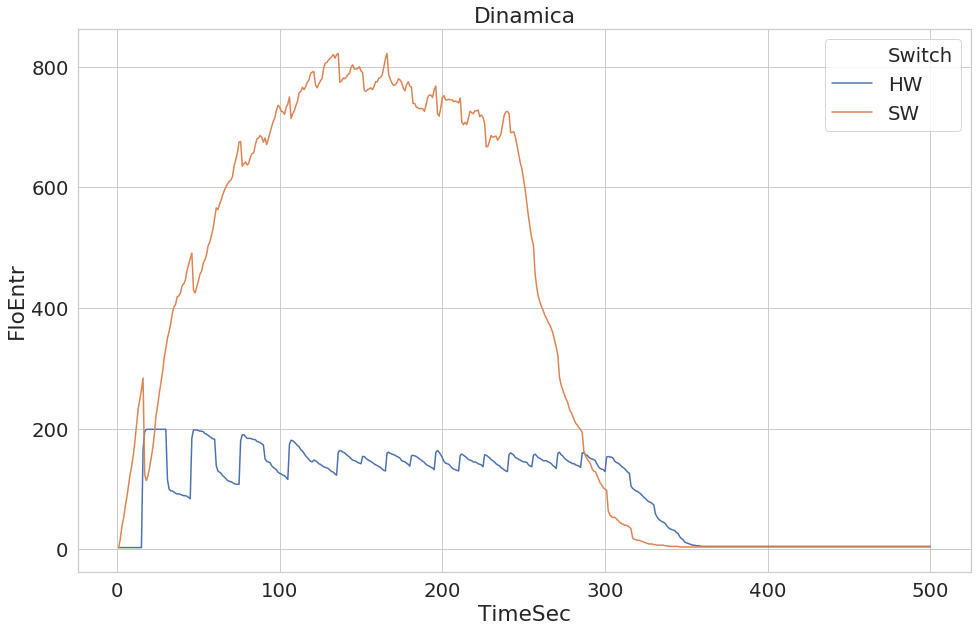

In [5]:
plt.figure(figsize=(16, 10))
ax = sns.lineplot(x="TimeSec", y="FloEntr",hue="Switch",data=dfSwitch_d)
plt.title('Dinamica')